In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import s3fs
import warnings
warnings.filterwarnings('ignore')

In [2]:
# df = pd.read_parquet("../data/Silver/eda_cleaned_HI-Medium_Trans.parquet")
df = pd.read_parquet("s3://bass-risk-monitoring/Silver/eda_cleaned_HI-Medium_Trans.parquet")

In [3]:
df.shape

(31898238, 19)

In [4]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'daily_txn_count'],
      dtype='object')

In [5]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,log_amount_paid,log_amount_received,hour,date,month,day_of_week,is_weekend,daily_txn_count
0,2022-09-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0,8.824035,8.824035,0,2022-09-01,2022-09,3,0,7
1,2022-09-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0,8.954194,8.954194,0,2022-09-01,2022-09,3,0,1
2,2022-09-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0,7.539681,7.539681,0,2022-09-01,2022-09,3,0,7
3,2022-09-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0,18.119128,18.119128,0,2022-09-01,2022-09,3,0,13
4,2022-09-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0,17.641288,17.641288,0,2022-09-01,2022-09,3,0,13


Feature engineering

In [6]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Is Laundering'] = df['Is Laundering'].astype('int8')

# chronological sort
df = df.sort_values('Timestamp').reset_index(drop=True)

print(f"Date range: {df['Timestamp'].min().date()} → {df['Timestamp'].max().date()}")
print(f"Laundering cases: {df['Is Laundering'].sum():,} ({df['Is Laundering'].mean()*100:.5f}%)")

Date range: 2022-09-01 → 2022-09-28
Laundering cases: 35,230 (0.11044%)


In [7]:
# sort
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

df_idx = df.set_index('Timestamp')

In [8]:
# 3. Lagged 7d & 30d rolling averages

lag_7d  = df_idx.groupby('Account')['Amount Paid'].rolling('7D',  min_periods=1).mean().shift(1)
lag_30d = df_idx.groupby('Account')['Amount Paid'].rolling('30D', min_periods=1).mean().shift(1)

df['lag_avg_7d']  = lag_7d.values
df['lag_avg_30d'] = lag_30d.values

In [9]:
df = df.reset_index(drop=True)

df['lag_avg_7d']  = df['lag_avg_7d'].fillna(0)
df['lag_avg_30d'] = df['lag_avg_30d'].fillna(0)

In [10]:

#  ratio features
df['amount_vs_7d_avg']  = df['Amount Paid'] / (df['lag_avg_7d']  + 1.0)
df['amount_vs_30d_avg'] = df['Amount Paid'] / (df['lag_avg_30d'] + 1.0)

In [11]:

# 24h txn count excluding current
df['_seq'] = df.groupby('Account').cumcount()
df['txn_count_24h_excl'] = df.groupby('Account')['_seq'].transform(
    lambda x: x.rolling(1440, min_periods=1).count() - 1
).fillna(0).astype('int16')
df.drop(columns=['_seq'], inplace=True)

In [12]:
# Time since last txn
df['time_since_last_txn'] = df.groupby('Account')['Timestamp'].diff().dt.total_seconds().fillna(0)
df.drop(columns=['daily_txn_count'], inplace=True, errors='ignore')


In [13]:

print(f"   amount_vs_7d_avg  max  = {df['amount_vs_7d_avg'].max():.1f}")
print(f"   amount_vs_30d_avg max  = {df['amount_vs_30d_avg'].max():.1f}")
print(f"   txn_count_24h_excl max = {df['txn_count_24h_excl'].max()}")
print(f"   Final shape: {df.shape}")


   amount_vs_7d_avg  max  = 202243218658.4
   amount_vs_30d_avg max  = 202243218658.4
   txn_count_24h_excl max = 1439
   Final shape: (31898238, 24)


In [14]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'lag_avg_7d', 'lag_avg_30d',
       'amount_vs_7d_avg', 'amount_vs_30d_avg', 'txn_count_24h_excl',
       'time_since_last_txn'],
      dtype='object')

In [15]:

# First laundering timestamp per criminal account
first_crime = df[df['Is Laundering'] == 1].groupby('Account')['Timestamp'].min()



In [16]:

df['first_crime_time'] = df['Account'].map(first_crime)

# transactions that happen AFTER a criminal has started laundering
future_of_criminal = (
    df['Account'].isin(first_crime.index) & 
    (df['Timestamp'] > df['first_crime_time'])
)


In [17]:

# target = 0 for all future transactions of known criminals
before = df['Is Laundering'].sum()
df.loc[future_of_criminal, 'Is Laundering'] = 0
after = df['Is Laundering'].sum()

In [18]:

df.drop(columns=['first_crime_time'], inplace=True)


In [22]:

print(f"   Laundering cases: {before:,} → {after:,} (dropped {before-after:,} future leaks)")
print(f"   Remaining positive rate: {df['Is Laundering'].mean()*100:.6f}%")
print(f"   Final shape: {df.shape}")


   Laundering cases: 35,230 → 22,772 (dropped 12,458 future leaks)
   Remaining positive rate: 0.071390%
   Final shape: (31898238, 24)


In [23]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'lag_avg_7d', 'lag_avg_30d',
       'amount_vs_7d_avg', 'amount_vs_30d_avg', 'txn_count_24h_excl',
       'time_since_last_txn'],
      dtype='object')

In [24]:
df.dtypes

Timestamp              datetime64[ns]
From Bank                       int32
Account                string[python]
To Bank                         int32
Account.1              string[python]
Amount Received               float64
Receiving Currency           category
Amount Paid                   float64
Payment Currency             category
Payment Format               category
Is Laundering                    int8
log_amount_paid               float64
log_amount_received           float64
hour                            int32
date                           object
month                       period[M]
day_of_week                     int32
is_weekend                      int64
lag_avg_7d                    float64
lag_avg_30d                   float64
amount_vs_7d_avg              float64
amount_vs_30d_avg             float64
txn_count_24h_excl              int16
time_since_last_txn           float64
dtype: object

### Feature Selection

Correlation Analysis

In [25]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()

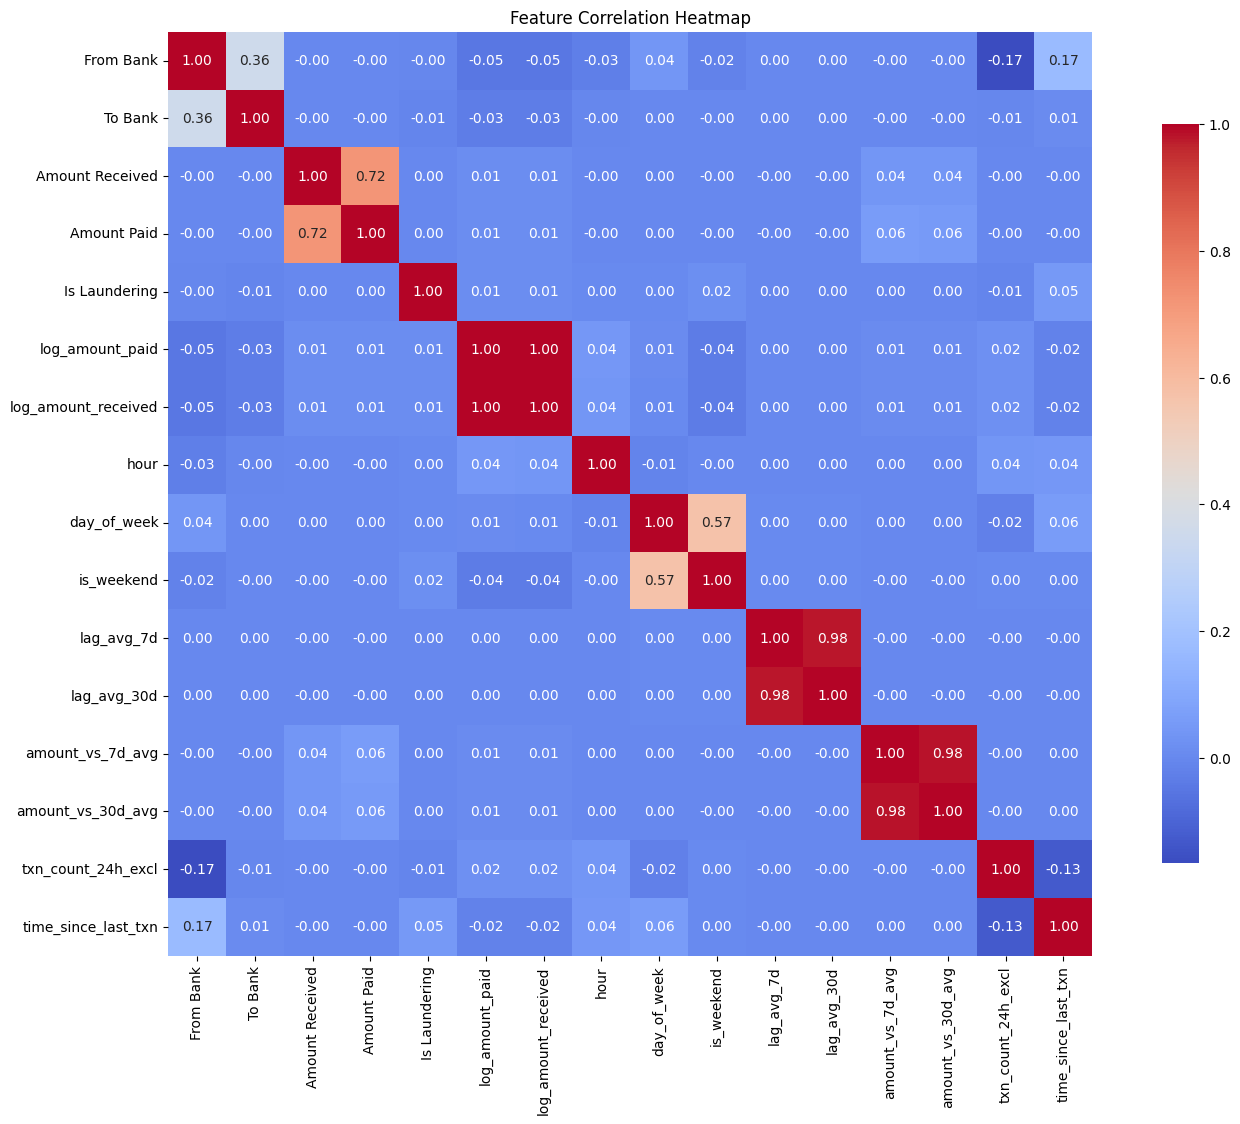

In [26]:

threshold = 0.9
corr_matrix = df[numeric_cols].corr()

# Correlation
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Heatmap")
plt.show()

In [27]:
#  high correlations threshold = 0.9

high_corr = (corr_matrix.abs() >= 0.90) & (corr_matrix != 1.0)
if high_corr.any().any():
    pairs = corr_matrix.where(high_corr).stack()
    for (f1, f2), val in pairs.items():
        print(f" {f1:25} - {f2:25} : {val: .3f}")
else:
    print("   No high correlations found ")

 log_amount_paid           - log_amount_received       :  0.997
 log_amount_received       - log_amount_paid           :  0.997
 lag_avg_7d                - lag_avg_30d               :  0.977
 lag_avg_30d               - lag_avg_7d                :  0.977
 amount_vs_7d_avg          - amount_vs_30d_avg         :  0.984
 amount_vs_30d_avg         - amount_vs_7d_avg          :  0.984


HIGH BUT EXPECTED CORRELATIONS 

1. log_amount_paid - log_amount_received : 0.997  
   - In this data, all transactions have Amount Paid = Amount Received  
   - Perfectly normal (most are reinvestments / same-currency transfers)

2. lag_avg_7d - lag_avg_30d : 0.977  
   - 7-day average is naturally very close to 30-day average early in the month  
   - Becomes less correlated later - model learns the difference when it matters

3. amount_vs_7d_avg - amount_vs_30d_avg : 0.984  
   - Same root cause: both ratios explode when a criminal suddenly transfers 1000× their normal amount  
   - The model uses the SHARPER 7-day ratio for immediate detection  
   - Keeps 30-day for context — this is a FEATURE, not a bug

Conclusion:  
All high correlations are INTERPRETABLE and BEHAVIORALLY JUSTIFIED  
No redundant or leaked features remain

In [ ]:
# drop the duplicate

df.drop(columns=['log_amount_received'], inplace=True, errors='ignore') 
df.drop(columns=['lag_avg_7d', 'lag_avg_30d'], inplace=True, errors='ignore')

In [32]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'hour', 'date', 'month', 'day_of_week', 'is_weekend',
       'amount_vs_7d_avg', 'amount_vs_30d_avg', 'txn_count_24h_excl',
       'time_since_last_txn'],
      dtype='object')

Feature importance

In [36]:
final_features = [
    'Amount Paid',
    'log_amount_paid',
    'hour',
    'day_of_week',
    'is_weekend',
    'amount_vs_7d_avg',
    'amount_vs_30d_avg',
    'txn_count_24h_excl',
    'time_since_last_txn'
]
gold_columns = ['Timestamp', 'Account', 'Is Laundering'] + final_features
df_gold = df[gold_columns].copy()

In [ ]:
df_gold = df_gold.loc[:, ~df_gold.columns.duplicated(keep='first')]
df_gold = df_gold[[c for c in df_gold.columns if not c.startswith('Unnamed')]]

In [40]:
df_gold.columns

Index(['Timestamp', 'Account', 'Is Laundering', 'Amount Paid',
       'log_amount_paid', 'hour', 'day_of_week', 'is_weekend',
       'amount_vs_7d_avg', 'amount_vs_30d_avg', 'txn_count_24h_excl',
       'time_since_last_txn'],
      dtype='object')

In [42]:
# path = "s3://bass-risk-monitoring/Gold/hi_medium_FINAL_GOLD.parquet"
# df_gold.to_parquet(path, index=False)
df_gold.to_parquet("../data/Gold/hi_medium_FINAL_GOLD.parquet", index=False)
print(f"GOLD DATASET SAVED")


GOLD DATASET SAVED
